# Model Implementation -  SVC

**Security DS - Proyecto 1**

Roberto Figueroa - 18306

Gustavo Méndez - 18500

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import reduce_memory_usage
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import seaborn as sns

from sklearn import metrics, model_selection, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from itertools import cycle
from utils import (
    get_roc_curves,
    get_model_metrics,
    k_fold_val
)

%matplotlib inline
pd.set_option("display.max_columns", None)

### Functions

In [20]:
def get_model_metrics(y_val, predictions, model_name):
    conf_matrix = confusion_matrix(y_val, predictions)
    accu = accuracy_score(y_val, predictions)
    _recall_score = recall_score(y_val, predictions, average='weighted')
    _precision_score = precision_score(y_val, predictions, average='weighted')
    _f1_score = f1_score(y_val, predictions, average='weighted')

    print(f"\n---Metrics for {model_name}---")
    print("\n Confusion Matrix\n", conf_matrix)
    print("\n Accuracy", accu)
    print("\n Precision", _precision_score)
    print("\n Recall", _recall_score)
    print("\n F1 Score", _f1_score)
    
    return conf_matrix


In [35]:
def get_roc_curves(y, y_pred):
    y_ = label_binarize(y, classes=[0, 1])
    pred = label_binarize(y_pred, classes=[0,1])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes=1
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(
        fpr[0],
        tpr[0],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[0],
    )
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()

In [37]:
def k_fold_val(model, X, y, model_name, splits=5):
    # Validation of model after train with train data
    k_folds_model_train = model_selection.KFold(n_splits=splits, shuffle=True, random_state=79)
    k_folds_model_train.get_n_splits(X)
    scores = model_selection.cross_val_score(model, X, y, cv=k_folds_model_train)
    print(f"---k-fold scores for {model_name}---")
    print("Scores are: ", scores)
    print("Mean is: ", np.mean(scores))
    print("STD is: +-", np.std(scores))

### Load Data

In [2]:
X_columns = ['AVProductsInstalled',
             'SmartScreen',
             'AVProductStatesIdentifier',
             'Census_OSArchitecture',
             'AppVersion_2',
             'Census_TotalPhysicalRAM',
             'IsProtected',
             'EngineVersion',
             'Census_SystemVolumeTotalCapacity',
             'CountryIdentifier',
             'OrganizationIdentifier',
             'AppVersion_3',
             'Census_FirmwareVersionIdentifier',
             'Census_ProcessorModelIdentifier',
             'Census_OEMModelIdentifier',
             'CountryIdentifier',
             'OrganizationIdentifier',
             'HasDetections'
             ]

In [3]:
df = pd.read_csv('./datasets/train_preprocessed.csv', usecols=X_columns)

In [4]:
# Warn: Do not execute except hardware limitations
df = df.sample(frac=0.25)

In [4]:
df.shape

(7667799, 16)

In [5]:
X = df.drop("HasDetections", axis=1)
y = df["HasDetections"]

del df

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### Model Implementation

In [15]:
clf = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=200, early_stopping=True, verbose=True))

In [16]:
clf.fit(X_train, y_train)

Iteration 1, loss = 0.64234112
Validation score: 0.625187
Iteration 2, loss = 0.63457611
Validation score: 0.626640
Iteration 3, loss = 0.63354217
Validation score: 0.628148
Iteration 4, loss = 0.63301436
Validation score: 0.628384
Iteration 5, loss = 0.63258803
Validation score: 0.628655
Iteration 6, loss = 0.63232998
Validation score: 0.629628
Iteration 7, loss = 0.63213493
Validation score: 0.629208
Iteration 8, loss = 0.63195003
Validation score: 0.628989
Iteration 9, loss = 0.63183108
Validation score: 0.630125
Iteration 10, loss = 0.63169382
Validation score: 0.629447
Iteration 11, loss = 0.63159918
Validation score: 0.629516
Iteration 12, loss = 0.63148625
Validation score: 0.629684
Iteration 13, loss = 0.63141633
Validation score: 0.629869
Iteration 14, loss = 0.63136010
Validation score: 0.630287
Iteration 15, loss = 0.63127638
Validation score: 0.629892
Iteration 16, loss = 0.63120484
Validation score: 0.630817
Iteration 17, loss = 0.63114339
Validation score: 0.629398
Iterat

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True, random_state=1,
                               verbose=True))])

### Predict

In [19]:
predictions = clf.predict(X_test)

### Metrics

In [21]:
conf_matrix = get_model_metrics(y_test, predictions, "MLPClassifier")


---Metrics for MLPClassifier---

 Confusion Matrix
 [[476550 287164]
 [276743 493103]]

 Accuracy 0.6322889225071077

 Precision 0.6322933758741142

 Recall 0.6322889225071077

 F1 Score 0.6322619487227563


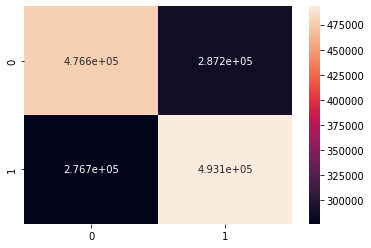

In [25]:
sns.heatmap(conf_matrix, annot=True, fmt=".4g");

### Cross Validation

In [ ]:
k_fold_val(clf, X, y, "MPLClassifier", splits=10)

### ROC Curve

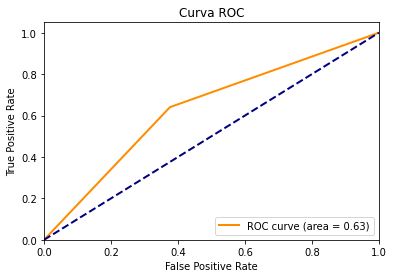

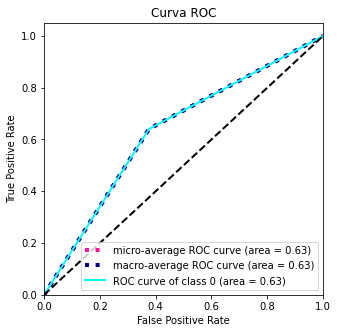

In [36]:
get_roc_curves(y_test, predictions)